In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from efficientnet_pytorch import EfficientNet

import time
import os
import numpy as np
import copy

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = 'Face_Position_dataset'

train_transforms = transforms.Compose([transforms.Resize((64, 64)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((64, 64)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/val', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [3]:
dataloaders_dict = {'train': trainloader, 'val':testloader}
for keys,items in dataloaders_dict.items():
    print(keys)
    
print(dataloaders_dict['train'].dataset.class_to_idx)    

train
val
{'Front': 0, 'Side': 1}


In [4]:
device = "cuda:0"

In [5]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes = 2)


Loaded pretrained weights for efficientnet-b0


In [6]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [7]:
def freeze(model):

    for param in model.parameters():

        param.require_grad = False
        
    return model

In [8]:
model=freeze(model)

In [9]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.0025)
model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [10]:
num_epochs=40

since = time.time()

train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
global inputs_, labels_

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0


        for inputs, labels in dataloaders_dict[phase]:
            inputs = inputs.to(device)

            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):

                output = model(inputs)

                loss = criterion(output, labels)
                _, preds = torch.max(output, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders_dict[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "ResNet10_best.pth")
            
        if phase == 'train':
            train_acc_history.append(epoch_acc)
            train_loss_history.append(epoch_loss)  

        if phase == 'val':
            val_acc_history.append(epoch_acc)
            val_loss_history.append(epoch_loss)


time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

Epoch 1/40
----------
train Loss: 0.2974 Acc: 0.8611
val Loss: 1.6708 Acc: 0.9008
Epoch 2/40
----------
train Loss: 0.1855 Acc: 0.9272
val Loss: 0.6446 Acc: 0.9286
Epoch 3/40
----------
train Loss: 0.1562 Acc: 0.9511
val Loss: 0.5538 Acc: 0.9127
Epoch 4/40
----------
train Loss: 0.1436 Acc: 0.9431
val Loss: 0.4071 Acc: 0.9246
Epoch 5/40
----------
train Loss: 0.0630 Acc: 0.9775
val Loss: 0.4082 Acc: 0.9484
Epoch 6/40
----------
train Loss: 0.0605 Acc: 0.9775
val Loss: 0.5471 Acc: 0.9603
Epoch 7/40
----------
train Loss: 0.0620 Acc: 0.9828
val Loss: 0.3620 Acc: 0.9405
Epoch 8/40
----------
train Loss: 0.1256 Acc: 0.9524
val Loss: 0.1754 Acc: 0.9683
Epoch 9/40
----------
train Loss: 0.0692 Acc: 0.9762
val Loss: 0.2053 Acc: 0.9563
Epoch 10/40
----------
train Loss: 0.1031 Acc: 0.9643
val Loss: 0.1178 Acc: 0.9643
Epoch 11/40
----------
train Loss: 0.0576 Acc: 0.9762
val Loss: 0.3208 Acc: 0.9167
Epoch 12/40
----------
train Loss: 0.0549 Acc: 0.9722
val Loss: 0.1362 Acc: 0.9722
Epoch 13/40
-

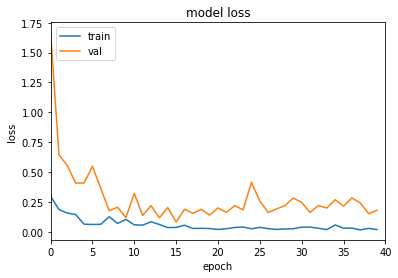

In [11]:
#summarize history for loss
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.xlim(0, num_epochs)
plt.show()